# Shipment Forecast

In [1]:
from src.model_utils import *
from src.estimator import *

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor

from boruta import BorutaPy

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf


import xgboost as xgb
import optuna
import lightgbm as lgb

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
optuna.logging.set_verbosity(optuna.logging.WARNING)

Importing plotly failed. Interactive plots will not work.


## Data loading

In [2]:
pos_data = pd.read_csv('data/pos.csv')
pos_data.head()

,Date,Sales
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


In [3]:
promo_data = pd.read_csv('data/promo.csv', header=None)
promo_data.head()

,0,1
0,2011-11-01,BlackFriday
1,2012-11-01,BlackFriday
2,2013-11-01,BlackFriday


In [4]:
shipment_data = pd.read_csv('data/shipment.csv')
shipment_data.head()

,Date,Shipments
0,2011-01-01,100
1,2011-02-01,319
2,2011-03-01,247
3,2011-04-01,238
4,2011-05-01,214


## Data exploration

### Set Date as index

In [5]:
pos_data.Date = pd.to_datetime(pos_data.Date)

promo_data.rename({0:'Date', 1:'BlackFriday'}, axis=1, inplace=True)
promo_data.Date = pd.to_datetime(promo_data.Date)

shipment_data.Date = pd.to_datetime(shipment_data.Date)

In [6]:
pos_data = pos_data.set_index('Date')
promo_data = promo_data.set_index('Date')
shipment_data = shipment_data.set_index('Date')

### Missing values

In [7]:
pos_data.isna().sum()

Sales    0
dtype: int64

In [8]:
promo_data.isna().sum()

BlackFriday    0
dtype: int64

In [9]:
shipment_data.isna().sum()

Shipments    0
dtype: int64

### Missing month

In [10]:
pos_data.asfreq('MS').isna().sum()

Sales    0
dtype: int64

In [11]:
shipment_data.asfreq('MS').isna().sum()

Shipments    0
dtype: int64

### Combine dataframes into one

In [12]:
data = pd.concat([pos_data, promo_data, shipment_data], axis=1)
data.BlackFriday = data.BlackFriday.replace("BlackFriday", 1)
data = data.fillna(0)
data

,Sales,BlackFriday,Shipments
Date,,,
2011-01-01,266.0,0.0,100
2011-02-01,145.9,0.0,319
2011-03-01,183.1,0.0,247
2011-04-01,119.3,0.0,238
2011-05-01,180.3,0.0,214
2011-06-01,168.5,0.0,188
2011-07-01,231.8,0.0,195
2011-08-01,224.5,0.0,209
2011-09-01,192.8,0.0,241


### Sales and Shipments time-series graph

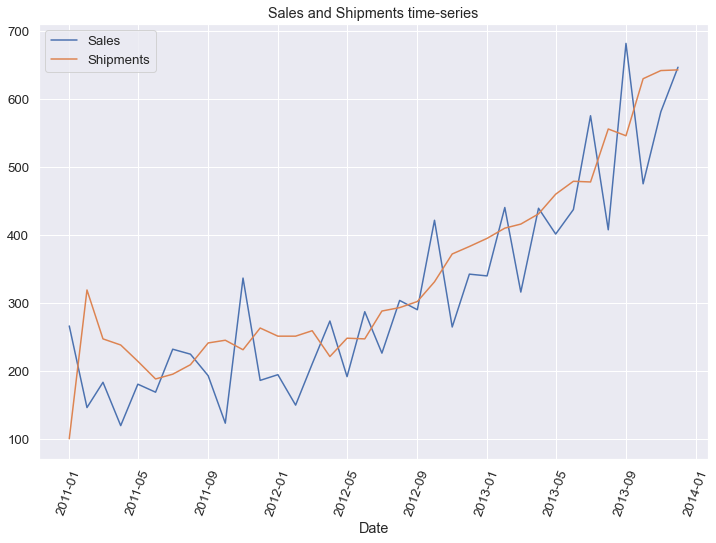

In [13]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.2)

plt.figure(figsize=(12,8))
plt.title('Sales and Shipments time-series')
sns.lineplot(x='Date', y='Sales', data=data, label='Sales')
sns.lineplot(x='Date', y='Shipments', data=data, label='Shipments')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=70);

- We observe the strange behaviour of `Shipments` in February 2011. It seems that shipping proceess wasn't set up, because we see that shipments started with the value of 100 at first, then it was a huge spike in February, and again shipments went down and then smoothly raised up. So to be sure in our predictions we'll get rid of this **spike anomaly** and our data will begin with March 2011.
- Since we have `BlackFridays` each November we would expect increasing of `Sales` this month. This graph hardly tells us that `Sales` increase each November, so we'll do time-series decomposition to clearly see the trend and seasonality.
- Sometimes `Shipments` are less than `Sales`, that may mean we have goods in stock.

### Time-series components

To isolate trend, seasonality and noise from time-series data we use decomposition. How decomposition works under the hood?<br> 
1. Identify the length of the seasonal period
2. Isolate the trend
3. Isolate the seasonality + noise
4. Isolate the seasonality
5. Isolate the noise

We'll use Multiplicative Decompose as the trend line grows exponentially and the peaks and valleys for seasonality aren't constant over time.

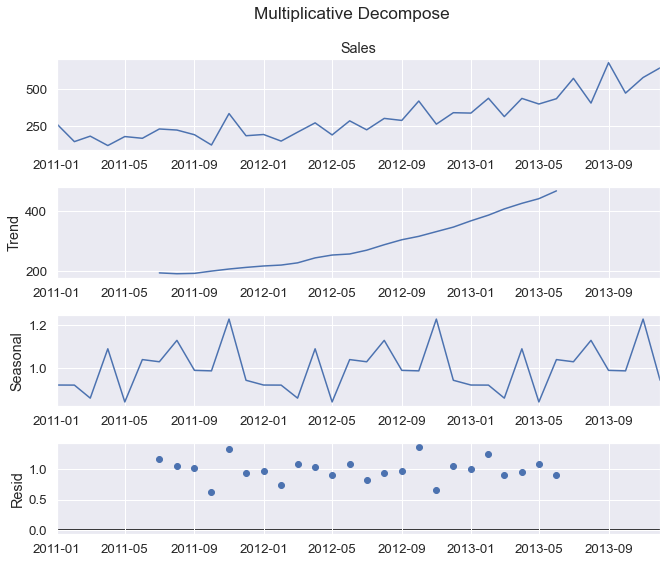

In [14]:
sales_decomp_mul = seasonal_decompose(pos_data.Sales, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

sales_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

We clearly see upward trend and some spikes in November (due to BlackFridays), April (probably due to Easter).

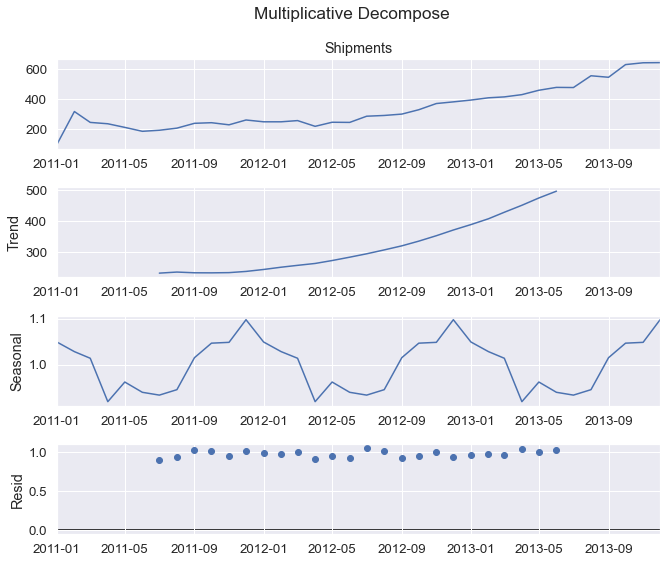

In [15]:
shipment_decomp_mul = seasonal_decompose(shipment_data.Shipments, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

shipment_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

There's also upward trend and spikes are in May and December. I may assume that Shipments increases these month to replenish stock after big Sales in April and November.

### Moving average

We'll proceed with **Simple Moving Average** (SMA) method for analysing the trend in our data. SMA is a rolling mean of the recent observations over a specific number of time periods.

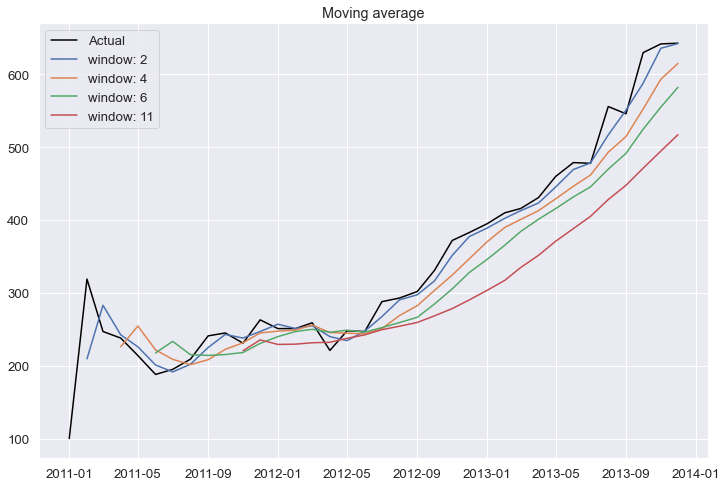

In [16]:
window_sizes = [2, 4, 6, 11]
plt.figure(figsize=(12,8))
plt.title('Moving average')
plt.plot(data.Shipments, label='Actual', color='black')

for window in window_sizes:
    rolling_mean = data.Shipments.rolling(window=window).mean()
    plt.plot(data.Shipments.index, rolling_mean, label=f'window: {window}')
    
plt.legend(loc='best')
plt.show()

So larger moving averages 12 gives better view of long term trend whereas smaller moving averages 2, 4 and 6 give granular details for short term data.

### Correcting the data

In [17]:
data = data[2:]

## Exponential Smoothing

As a baseline model we'll use Exponential Smoothing. It weights all available observations while exponentially decreasing the weights as we move further back in time. 

### Simple exponential smoothing

The mathematical notation for this method is: $$\hat{y}_x = \alpha y_x + (1 - \alpha)\hat{y}_{x-1}$$ 

So we pick an  $0 < \alpha < 1$ (also called **the smoothing factor**) and a starting value $\hat{y}_0$ (the first value of the observed data) and then calculate $\hat{y}_x$ for $x = \overline{1, n}$ (also referred to as **levels**). <br> $\alpha$ defines **how quickly we forget the last available true observation.** The smaller $\alpha$ is, the more influence the previous historical observations have and the smoother the series is, whereas larger values of $\alpha$ mean that the model pays attention mainly to the most recent past observations.

### Double exponential smoothing

Double Exponential Smoothing is an extension to Simple Exponential Smoothing that **explicitly adds support for trends** in the univariate time series. In addition to the $\alpha$ parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend - $\beta$. <br> Before we dive deeeper into mathematical formulas, let's introduce two notations: **the current trend**, denoted by $b$ (we can think of it as the slope of the time series), and **the current level**, denoted by $l$. 

Some math behind this idea: 
$$l_x = \alpha y_x + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$\hat{y}_{x+1} = l_x + b_x$$ 

- $l$, level is simply predicted point. It's a part of calculation of the forecast.
- Bigger values of $0<\beta<1$ mean that the model don't give much weight to the past trends when estimating current trend.
- The method supports **trend that changes in different ways: an additive and a multiplicative**, depending on whether the trend is linear or exponential respectively. Double Exponential Smoothing with an additive trend is classically referred to as **Holt’s linear trend model**. To compute the initial additive trend we may use the first two points: $y_x - y_{x-1}$. When the trend is multiplicative we could use the ratio $y_x / y_{x-1}$.

### Triple exponential smoothing

The idea behind this method (also called **Holt-Winters Method**) is to apply Exponential Smoothing to a third component - **seasonality**, $s$. This seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words, by the period which the variations repeats itself. So for each observation in the season, there will be a separate component. 
<br> The mathematical notation for this method is:
$$l_x = \alpha (y_x - s_{x-L}) + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$s_x = \gamma(y_x - l_{x}) + (1 - \gamma)s_{x-L}$$ 
$$\hat{y}_{x+m} = l_x + m b_x + s_{x-L+(m-1)modL}$$

- $L$, season length is the number of data points after which a new season begins.
- There is a new parameter  $0<\gamma<1$ that controls the influence on the seasonal component.
- The index for the forecast $\hat{y}_{x+m}$ is $x+m$ where $m$ can be any integer. It means we can forecast any number of points into the future while accounting for previous value, trend and seasonality.
- The index of the seasonal component $s_{x-L+(m-1)modL}$ offsets into our observed data list of seasonal components. 
<br> For example, if we are forecasting the 3rd point into the season, and we are 12 seasons into the future, we cannot use seasonal components from the 11th season in the future since that season is also generated by our forecasting procedure, we must use the last set of seasonal components from observed points, or from "the past".


**Initial values for the trend factor**
<br>The most common practice here is to compute the average trend averages across seasons:
$$b = \frac{1}{L}(\frac{y_{L+1} - y_1}{L} + \frac{y_{L+2} - y_2}{L} + \ldots + \frac{y_{L+L} - y_L}{L})$$

**Initial values for the seasonal indices**
<br> We need:
- to compute the averages for every observed season 
- to subtract every observed value by the average for the season it's in
- to  average each of these numbers across our observed seasons

### Optimizing parameters with GridSearch

Through a lot of experiments that I've made with diffrenet types of Exponential Smoothing, the performance of triple exponential smoothing model was the best as our data includes both trend and seasonality components. <br>
Let's find optimal parameters by using **Grid Search**. In a nutshell Grid Search finds the best hyperparameters by simple **brute force**. One of the major drawbacks of grid search is that when it comes to dimensionality, it suffers when the number of hyperparameters grows exponentially.

In [18]:
parameters = {
    'trend': ['add'],
    'seasonal': ['add'],
    'seasonal_periods': [12],
    'smoothing_level': np.linspace(0.1, 0.5, 3),
    'smoothing_trend': np.linspace(0.5, 1, 6),
    'smoothing_seasonal': np.linspace(0.5, 1, 6)
}


tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(ExpEstimator(), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

X, y = data.Shipments.values, data.Shipments.values
grid_result = grid.fit(X[:-5], y[:-5])

So the parameters that gave the best result on cross-validation are:

In [19]:
exp_params = grid_result.best_params_
exp_params

{'seasonal': 'add',
 'seasonal_periods': 12,
 'smoothing_level': 0.30000000000000004,
 'smoothing_seasonal': 0.5,
 'smoothing_trend': 1.0,
 'trend': 'add'}

In [20]:
exp_mape = -grid_result.best_score_
exp_std = pd.DataFrame(grid_result.cv_results_).iloc[grid_result.best_index_]['std_test_score']
print(f'For these parameters:\tmape = {exp_mape}, std = {exp_std}')

For these parameters:	mape = 0.034587825638882255, std = 0.03371000046587815


std = 0.018792415239673788
mape = 0.04969029477527877


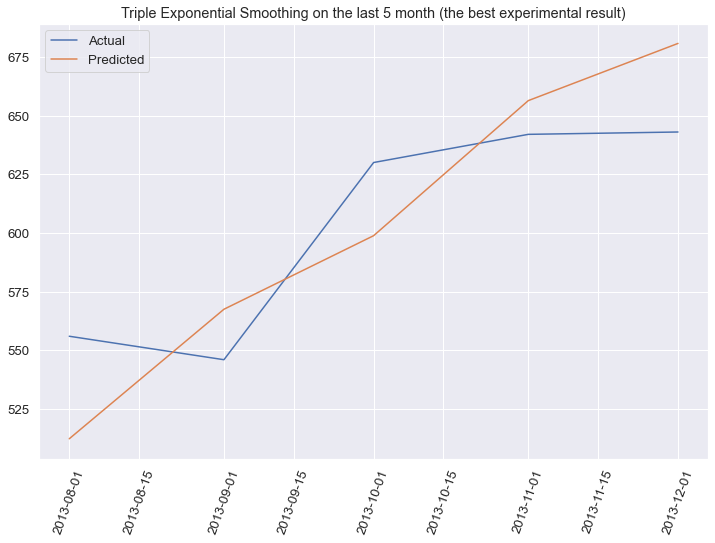

In [21]:
x = data.Shipments[-5:].index.values
y_true = data.Shipments[-5:].values

model = ExpEstimator(**exp_params)
exp_std_err, exp_mape_err, exp_predicted_values = evaluate(model, X, y) 
print(f'std = {exp_std_err}\nmape = {exp_mape_err}')
plot_results(x, y_true, exp_predicted_values, title='Triple Exponential Smoothing on the last 5 month (the best experimental result)')

With triple exponential smoothing we got **MAPE of 4.97%** and **std of 1.88%** that are quite good results!

## Linear regression using Lag features

Another different method to forecast a time-series is to use past values called **Lags as predictors in Linear Regression model**.

### Use two lags - initial model

As we predict `Shipments` in the current month for the next one month and we know `Shipments` for the previous month but we don't know yet `Sales` for the previous month, we'll take **Lag_1** for `Shipments` and **Lag_2** for `Sales`.

<br> **Note: As we use lags as features, there're NaNs in our data and we should handle it.**
- **Zero** isn't a reasonable value to be replaced with.
- Replacing missing values with **mean or median** can data leak also computing mean and median doesn't consider trend/seasonality.
- **Last Observation Carried Forward and Next Observation Carried Backward techiques** also don't make sense within our task.
- As NaNs are continuous from the beggining to the N-th lag, **interpolation methods** are also not the way of handling missing data caused by lags.

Therefore, we'll just **drop NaNs** that appeared after creating of lags.

In [22]:
data_lag = data.copy()

In [23]:
data_lag = data.copy()
sales_lags = make_lags(data_lag.Sales, [2])
shipments_lags = make_lags(data_lag.Shipments, [1])

X, y = get_X_y_from_lagged_df([sales_lags, shipments_lags, data_lag[['BlackFriday']]], data_lag.Shipments)
X = X.values

In [24]:
lin_reg = LinearRegression()

std = 0.024077399669130237
mape = 0.0824351189642061


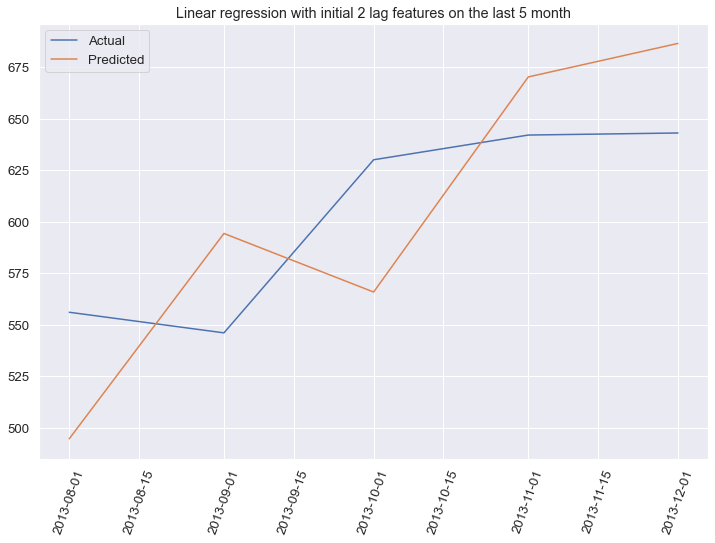

In [25]:
lr_init_std_err, lr_init_mape_err, lr_init_predicted_values = evaluate(lin_reg, X, y)
print(f'std = {lr_init_std_err}\nmape = {lr_init_mape_err}')
plot_results(x, y_true, lr_init_predicted_values, title='Linear regression with initial 2 lag features on the last 5 month')

So we took only 2 lags and got MAPE of 8.24% and std of 2.41%. We can improve our results by choosing more lags. 

### Choosing lags

When choosing lags to use as features, it generally won't be useful to include every lag because we may end up with large autocorrelation. We'll use different techhiques to choose lags in order to get the best model performance.

### Partial Autocorrelation plot

Plotting the partial autocorrelation may help us to choose which lag features to use.
<br> Partial autocorrelation can be imagined as the **pure correlation** between the series and its lag, after excluding the contributions from the intermediate lags. So it's the relation between observed at two-time spots given that we consider both observations are correlated to the observations at other time spots.

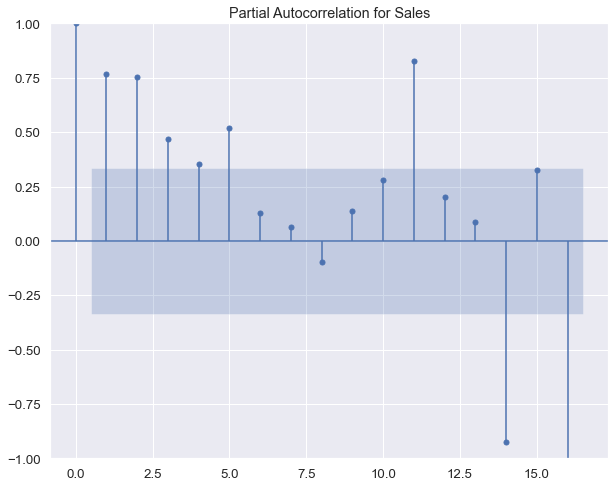

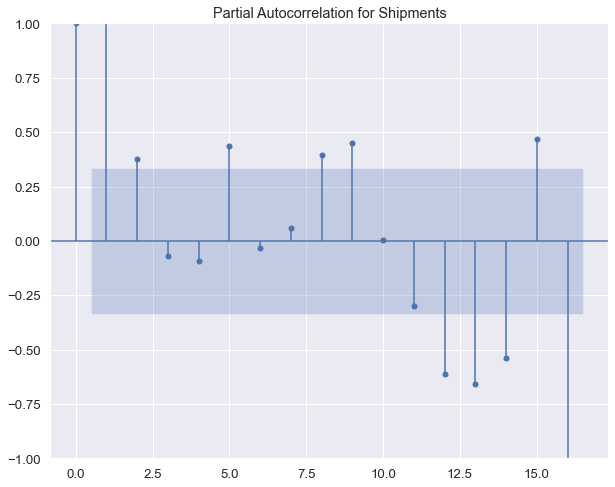

In [26]:
plot_pacf(data.Sales, method='ols') 
plt.title('Partial Autocorrelation for Sales')

plot_pacf(data.Shipments, method='ols') 
plt.title('Partial Autocorrelation for Shipments')
plt.show()

We used the **ols** (ordinary least squares) method as it fits a linear regression model with intercept using the original series as the target and the lagged series as the features. The main difference between two ols methods (efficient and inefficient) is that in the efficient approach we iteratively decreased the number of observations whereas in the inefficient we remove the first N (amount of lags) observations at the beginning.
<br><p>In the partial autocorrelation plot, the light blue area shows the significant threshold value, and every vertical line indicates the PACF values at each time spot. So in the plot, only the vertical lines that exceed the light blue area are considered significant. Lag_0 is time-series itself so the correlation is always equal to 1.

- For `Sales` we'll choose **Lag_2, Lag_3, Lag_5**. Even though at Lag_1 we'll see high correlation, we don't choose it as we don't know `Sales` for the previous month according to the task.
- For `Shipments` we'll choose **Lag_1, Lag_2**.

In [27]:
data_lag = data.copy()
sales_lags = make_lags(data_lag.Sales, [2, 3, 5])
shipments_lags = make_lags(data_lag.Shipments, [1, 2])

X, y = get_X_y_from_lagged_df([sales_lags, shipments_lags, data_lag[['BlackFriday']]], data_lag.Shipments)
X = X.values

std = 0.027313176050081885
mape = 0.046401891921305935


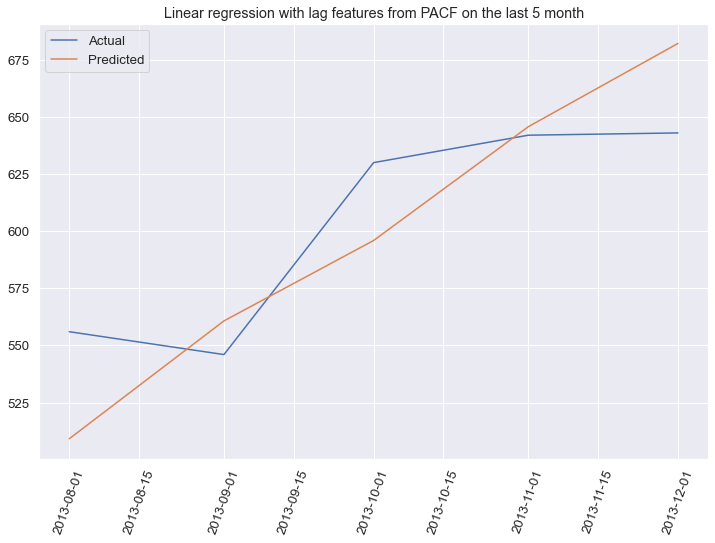

In [28]:
lr_pacf_std_err, lr_pacf_mape_err, lr_pacf_predicted_values = evaluate(lin_reg, X, y)
print(f'std = {lr_pacf_std_err}\nmape = {lr_pacf_mape_err}')
plot_results(x, y_true, lr_pacf_predicted_values, title='Linear regression with lag features from PACF on the last 5 month')

As we choosed more lags for `Sales` we **decreased MAPE on 3.6% and std is increased on 0.32%**. But for now we did it manually with the help of partial autocorrelation plot. Let's use some feature selection methods and see what lags as features will be choosen. 

### Feature Selection techniques

We'll cover:
- Lasso + SelectFromModel
- RandomForestRegressor + Boruta

The idea is to use a baseline model to evaluate features, so the model should clearly show the importance of the features used. As a basiline model wi'll use: linear model Lasso, that tends to produce zero coefficients, and RandomForrest. The logic is clear: if the features are clearly useless in a simple model, then there is no need to drag them into a more complex one.

#### Lasso + SelectFromModel

SelectFromModel keeps features whose importance (estimated by Lasso) is greater or equal than a specific threshold (mean, median or in a case with Lasso threshold equals to 1e-5), while others are discard.

In [29]:
data_lag = data.copy()

sales_lags = make_lags(data_lag.Sales, list(range(2, 6)))
shipments_lags = make_lags(data_lag.Shipments, list(range(1, 6)))

res = pd.concat([sales_lags, shipments_lags], axis=1)
res.dropna(inplace=True)

In [30]:
scaler = StandardScaler()
res_scaled = pd.DataFrame(scaler.fit_transform(res[:-5]), columns=res.columns)
df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[5:-5].reset_index(drop=True)], axis=1)

In [31]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][5:-5])

In [32]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model, prefit=True)

In [33]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

['Sales_lag_4', 'Shipments_lag_1', 'Shipments_lag_2', 'Shipments_lag_5']

In [34]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)

In [35]:
X, y = reduced_data.values, data_lag.Shipments[5:]

std = 0.029377583097210423
mape = 0.05146864983649907


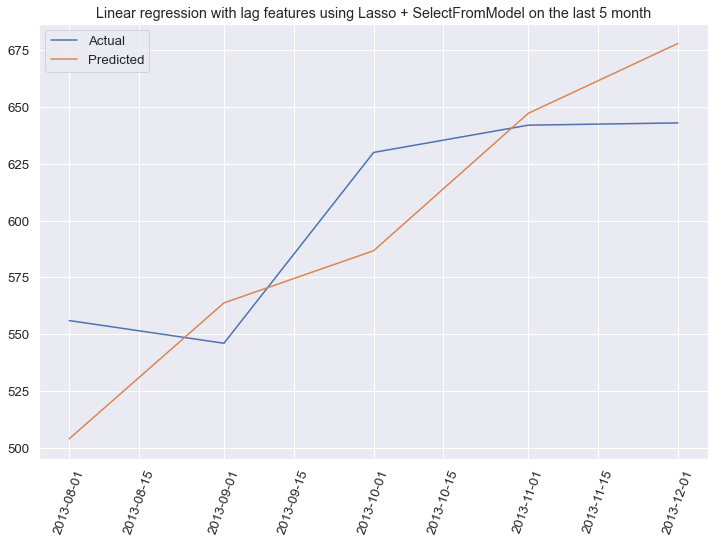

In [36]:
lr_lasso_std_err, lr_lasso_mape_err, lr_lasso_predicted_values = evaluate(lin_reg, X, y)
print(f'std = {lr_lasso_std_err}\nmape = {lr_lasso_mape_err}')
plot_results(x, y_true, lr_lasso_predicted_values, title='Linear regression with lag features using Lasso + SelectFromModel on the last 5 month')

So columns are different with those that we seleted manually above. Let's now see the importance of each feature estimated by Lasso.

In [37]:
feature_importance = list(zip(selection_model.feature_names_in_, selection_model.coef_))

for feat in feature_importance:
    print('Feature: {:<25} Importance: {}'.format(feat[0], feat[1]))

Feature: Sales_lag_2               Importance: 0.0
Feature: Sales_lag_3               Importance: 0.0
Feature: Sales_lag_4               Importance: 0.012947561412364491
Feature: Sales_lag_5               Importance: 0.0
Feature: Shipments_lag_1           Importance: 0.7025056353596816
Feature: Shipments_lag_2           Importance: 0.14800523116261868
Feature: Shipments_lag_3           Importance: 0.0
Feature: Shipments_lag_4           Importance: 0.0
Feature: Shipments_lag_5           Importance: 0.02389985691228791
Feature: BlackFriday               Importance: 0.0


So the biggest coefficient is for Shipments_lag_1, which is not suprising for us (as wee saw at PACF), other results also make sense (if we look at our seasonality graphs at the very beginning). Now we'll try to improve our results by tunning hyperparameters.

#### GridSearch + Lasso

In [38]:
parameters = {
    'alpha': np.linspace(0.1, 1, 10), 
    'fit_intercept':['True', 'False']
}

In [39]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(Lasso(), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

In [40]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][5:-5])
grid_result = grid.fit(X, y)

In [41]:
grid_result.best_params_

{'alpha': 0.1, 'fit_intercept': 'True'}

So as the best parameters of GridSearch are the same that we used previously with Lasso model, we'll move on and try another baseline model as an estimator - RandomForest, and one more selection technique Boruta.

#### RandomForestRegressor + Boruta

The idea underlying Boruta is to create random copies (**shadow features**) of all the features from the original dataset and train classifiers based on this extended dataset. We take the importance of each original features and compare it with a threshold. The threshold is defined as the highest feature importance recorded among the shadow features. When the importance of a feature is higher than this threshold, this is called a **hit**. The idea is that **a feature is useful only if it’s capable of doing better than the best randomized feature**.
<br><p>**What's the probability that we shall keep a feature?** The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin. Since each independent experiment can give a binary outcome (hit or no hit), a series of $n$ trials follows a **binomial distribution**.
<br><p>There're 3 areas: an **area of refusal**, an **area of irresolution**, an **area of acceptance**.

In [42]:
forest = RandomForestRegressor(
    n_jobs=-1, 
    max_depth=5,
    random_state=42
)
boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    random_state=42
)

In [43]:
sales_lags = make_lags(data_lag.Sales, list(range(2, 6)))
shipments_lags = make_lags(data_lag.Shipments, list(range(1, 6)))

X_df, y = get_X_y_from_lagged_df([sales_lags, shipments_lags, data_lag[['BlackFriday']]], data_lag.Shipments)
X = X_df.values

In [44]:
X_train, y_train = X[:-5], y[:-5]
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=84,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F96C5439940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F96C5439940)

In [45]:
feature_ranks = list(zip(X_df.columns, boruta.ranking_, boruta.support_))


for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Sales_lag_2               Rank: 1,  Keep: True
Feature: Sales_lag_3               Rank: 1,  Keep: True
Feature: Sales_lag_4               Rank: 1,  Keep: True
Feature: Sales_lag_5               Rank: 2,  Keep: False
Feature: Shipments_lag_1           Rank: 1,  Keep: True
Feature: Shipments_lag_2           Rank: 1,  Keep: True
Feature: Shipments_lag_3           Rank: 1,  Keep: True
Feature: Shipments_lag_4           Rank: 1,  Keep: True
Feature: Shipments_lag_5           Rank: 1,  Keep: True
Feature: BlackFriday               Rank: 3,  Keep: False


In [46]:
cols = X_df.columns[boruta.support_].to_list()

delete = [c for c in X_df.columns.values.tolist() if c not in cols]
reduced_data = X_df.drop(delete, axis=1)

std = 0.02484099383824941
mape = 0.049363860469083296


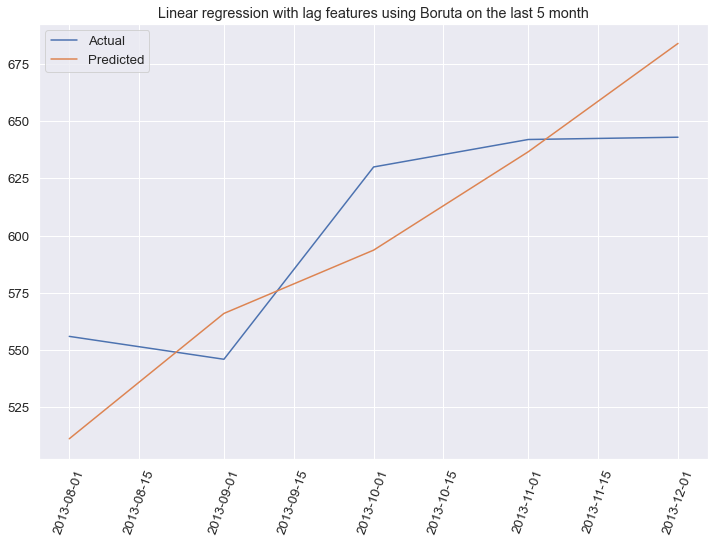

In [47]:
X = reduced_data.values

lr_boruta_std_err, lr_boruta_mape_err, lr_boruta_predicted_values = evaluate(lin_reg, X, y)
print(f'std = {lr_boruta_std_err}\nmape = {lr_boruta_mape_err}')
plot_results(x, y_true, lr_boruta_predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

The results are definetely better applying RandomForest and Boruta.  Let's try to tune parameters of RandomForest in order to improve the results a bit more.

#### GridSearch + RandomForestRegressor

In [48]:
parameters = {
    'n_estimators': [20, 40, 60],
    'max_depth': [3, 5, 7, 11],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [3, 5, 7]
}  

In [49]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

grid_result = grid.fit(X_train, y_train)

grid_result.best_params_

{'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 40}

In [50]:
forest = RandomForestRegressor(**grid_result.best_params_, random_state=42)

boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    random_state=42
)
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=3, min_samples_leaf=3,
                                         n_estimators=141,
                                         random_state=RandomState(MT19937) at 0x7F96C522BE40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F96C522BE40)

In [51]:
feature_ranks = list(zip(X_df.columns, boruta.ranking_, boruta.support_))

for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Sales_lag_2               Rank: 1,  Keep: True
Feature: Sales_lag_3               Rank: 1,  Keep: True
Feature: Sales_lag_4               Rank: 1,  Keep: True
Feature: Sales_lag_5               Rank: 2,  Keep: False
Feature: Shipments_lag_1           Rank: 1,  Keep: True
Feature: Shipments_lag_2           Rank: 1,  Keep: True
Feature: Shipments_lag_3           Rank: 1,  Keep: True
Feature: Shipments_lag_4           Rank: 1,  Keep: True
Feature: Shipments_lag_5           Rank: 1,  Keep: True
Feature: BlackFriday               Rank: 3,  Keep: False


std = 0.02484099383824941
mape = 0.049363860469083296


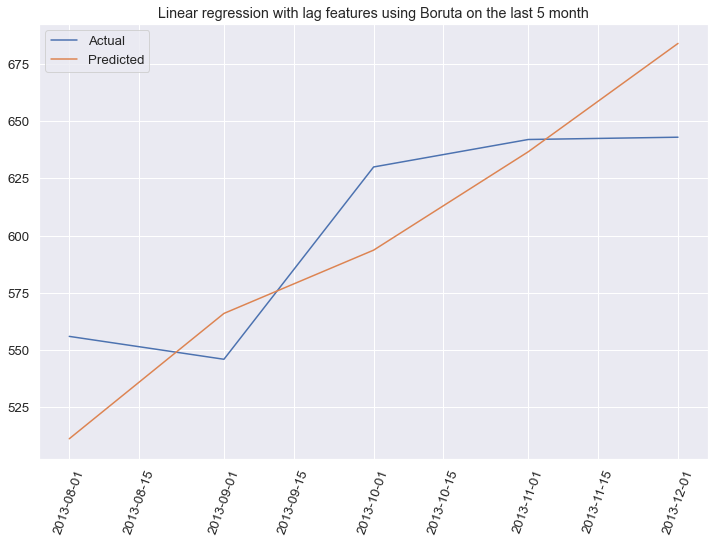

In [52]:
delete = [c for c in X_df.columns.values.tolist() if c not in cols]
reduced_data = X_df.drop(delete, axis=1)

X, y = reduced_data.values, data_lag.Shipments[5:]

std_err, mape_err, predicted_values = evaluate(lin_reg, X, y)
print(f'std = {std_err}\nmape = {mape_err}')
plot_results(x, y_true, predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

The best parameters of Random Forest obtained from parameter tuning gave us the same result that default parameters.
<br>So far we used Linear Regression model, now we'll proceed with more complex model - XGBoost on features that were selected by Boruta.

## XGBoost

Recap that **boosting** is a sequential ensemble learning technique to convert a weak hypothesis or weak learners into strong learners to increase the accuracy of the model. **XGBoost** is a framework of **gradient boosting** which is a special case of boosting algorithm where errors are minimized by a gradient descent algorithm and produce a model in the form of weak prediction models like decision trees. The strength of **XGBoost** is **parallelism** and **hardware optimization**. 


### Optimizing parameters with Optuna

As there're so many hyperparameters to optimize in XGBoost we should think of more efficient optimization than just a simple brute force that Grid Search implements. This is where Optuna comes.<br>
**Optuna** combines **sampling** and **pruning** mechanisms to provide efficient hyperparameter optimization.
- **Pruning Mechanism**

A **pruning mechanism** refers to the termination of unpromising trials during hyperparameter optimization. It periodically monitors each trial's learning curves. It then determines the sets of hyperparameters that will not lead to a good result and should not be taken into account.

- **Sampling Methods**

Optuna allows to build and manipulate hyperparameter search spaces dynamically. To sample configurations from search space, there'are two **sampling types**:

1. **Relational sampling**: these types of methods take into account information about the correlation among the parameters.
2. **Independent sampling**.

The default sampler in Optuna (**Tree-structured Parzen Estimator - TPE**) uses the history of previously evaluated hyperparameter configurations to sample the following ones.

**Note:** we'll use decision trees as weak learners in XGBoost, so we first detrend our data, as decision trees are so bad at extrapolation. One way to remove trend from our time-series is to calculate the difference of an element of time-series compared with previous element.

In [118]:
X, y = data_lag, data_lag.Shipments

In [119]:
sales_lags = [2, 3, 4]
shipments_lags = [1, 2, 3, 4, 5]

sales_transformer = Pipeline([
    ('sales_lags', FunctionTransformer(make_lags, kw_args={'lags':sales_lags})),
    ('sales_diff', FunctionTransformer(difference))
])

shipmnets_transformer = Pipeline([
    ('shipments_lags', FunctionTransformer(make_lags, kw_args={'lags':shipments_lags})),
    ('shipments_diff', FunctionTransformer(difference))
])

preprocessor = ColumnTransformer([
    ('sales_preprocess', sales_transformer, 'Sales'),
    ('shipments_preprocess', shipmnets_transformer, 'Shipments')
])

In [120]:
def objective(trial):
    
    param = {
            'objective': 'reg:squarederror',
            'booster': 'gbtree',
            'n_estimators': trial.suggest_int('n_estimators', 25, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 6),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
            'lambda': trial.suggest_float('lambda', 1e-8, 1e-3, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1e-3, log=True),
            'gamma': trial.suggest_float('gamma', 1e-8, 1e-3, log=True)
    }
    
    pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TransformedTargetRegressor(regressor=xgb.XGBRegressor(**param),
                                         transformer=TargetTransform(),
                                         check_inverse=False))
    ])
    
    std_err, mape_err, predicted_values = evaluate(pipe, X[:-5], y[:-5])
    
    return mape_err

In [121]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
xgb_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in xgb_params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.01231995722539279
  Params: 
    n_estimators: 49
    max_depth: 6
    min_child_weight: 6
    subsample: 0.11434049725189904
    colsample_bytree: 0.5226281430845806
    eta: 0.992869172940565
    lambda: 0.0001309482615376973
    alpha: 0.0009311000367901874
    gamma: 2.2329691143774733e-08


/var/folders/br/kh5mbckn2lngrc0_2lm9zk3m0000gn/T/ipykernel_27572/616175072.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study);


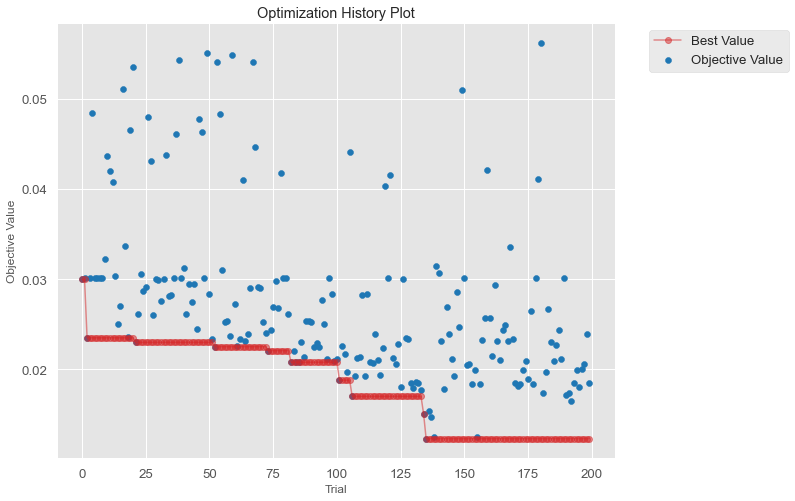

In [123]:
optuna.visualization.matplotlib.plot_optimization_history(study);

std = 0.05189729027952283
mape = 0.05875224640583647


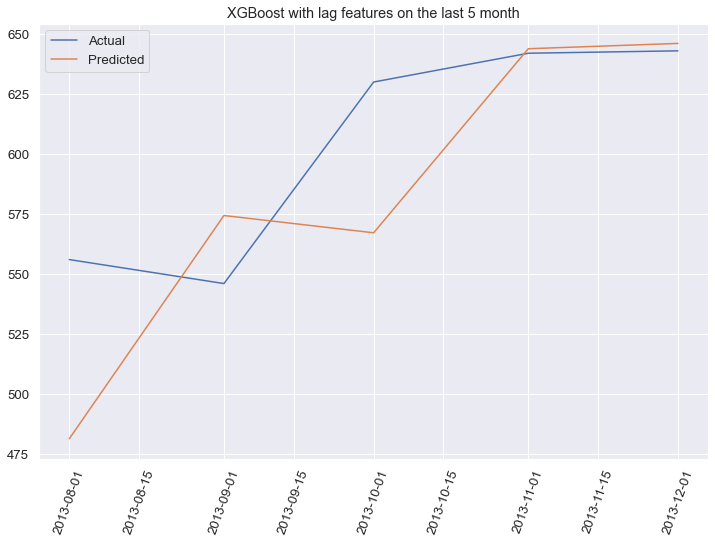

In [122]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TransformedTargetRegressor(regressor=xgb.XGBRegressor(**xgb_params),
                                         transformer=TargetTransform(),
                                         check_inverse=False))
])

xgb_std_err, xgb_mape_err, pred_values = evaluate(pipe, X, y)
print(f'std = {xgb_std_err}\nmape = {xgb_mape_err}')
plot_results(x, y_true, pred_values, title='XGBoost with lag features on the last 5 month')

std = 0.04884502857259248
mape = 0.06314251412595609


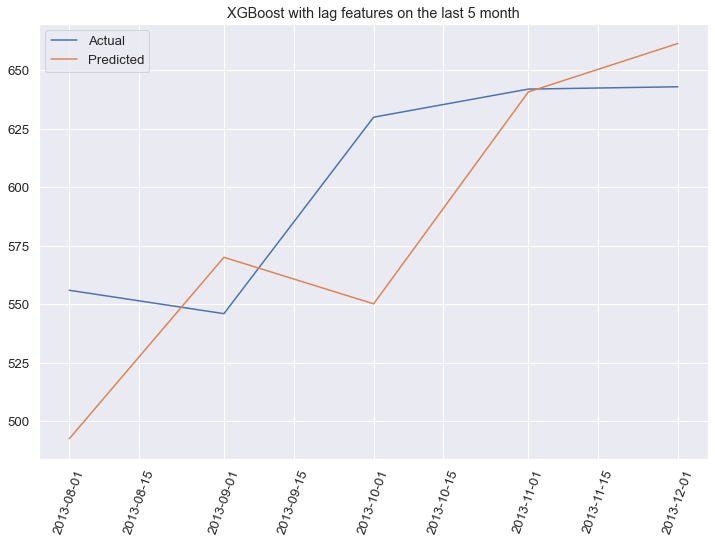

In [58]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TransformedTargetRegressor(regressor=xgb.XGBRegressor(**xgb_params),
                                         transformer=TargetTransform(),
                                         check_inverse=False))
])

xgb_std_err, xgb_mape_err, pred_values = evaluate(pipe, X, y)
print(f'std = {xgb_std_err}\nmape = {xgb_mape_err}')
plot_results(x, y_true, pred_values, title='XGBoost with lag features on the last 5 month')

So XGBoost gave us mape of 6.31%.

## Phrophet

### With holidays

In [ ]:
data_prophet = shipment_data[2:].copy()
data_prophet.reset_index(inplace=True)

X = data_prophet.values
y = data.Shipments.values

black_friday = promo_data.reset_index()
black_friday.columns = ['ds', 'holiday']

prophet_model = ProphetEstimator(holidays=black_friday)

prophet_init_std_err, prophet_init_mape_err, prophet_init_predicted_values = evaluate(prophet_model, X, y)

std = 0.03512751752087778
mape = 0.04859167174579966


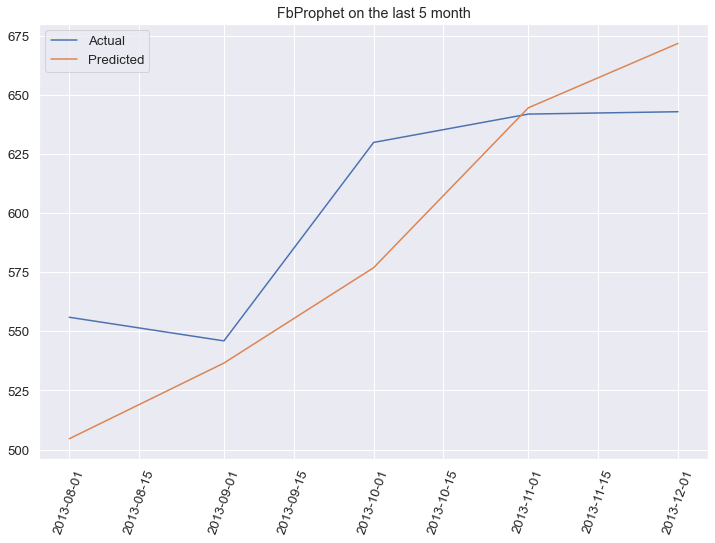

In [93]:
print(f'std = {prophet_init_std_err}\nmape = {prophet_init_mape_err}')
plot_results(x, y_true, prophet_init_predicted_values, title='FbProphet on the last 5 month')

### With holidays with linear trend

In [ ]:
data_prophet.Shipments = np.log(data_prophet.Shipments)
X = data_prophet.values
y = data.Shipments.values

model = TransformedTargetRegressor(regressor=prophet_model,
                                   func=np.log, 
                                   inverse_func=np.exp)

prophet_std_err, prophet_mape_err, prophet_predicted_values = evaluate(model, X, y)

std = 0.029350613093024395
mape = 0.06054215330878497


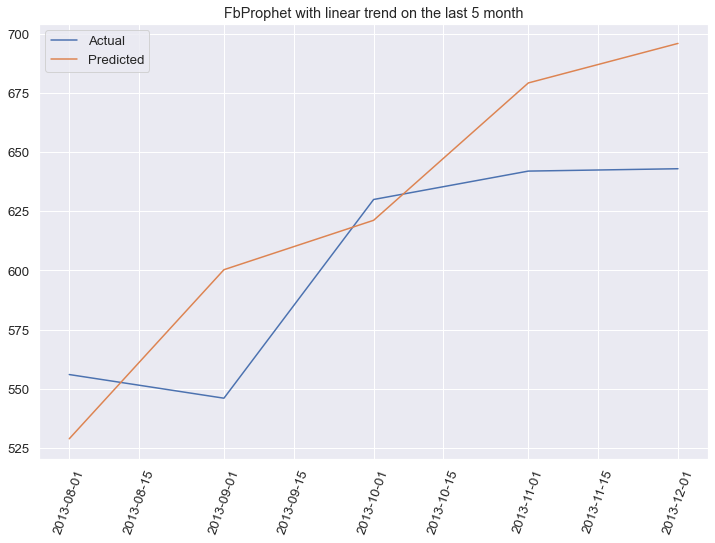

In [95]:
print(f'std = {prophet_std_err}\nmape = {prophet_mape_err}')
plot_results(x, y_true, prophet_predicted_values, title='FbProphet with linear trend on the last 5 month')

## Final thoughts

In [96]:
results = {
    'model': ['Holt-Winters Exp Smoothing', 'Linear Regression', 'Linear Regression', 'Linear Regression', 'Linear Regression', 'XGBoost', 'FbProphet', 'FbProphet'],
    'params': [exp_params, '–', '–', '–', '–', xgb_params, 'holidays', 'holidays'],
    'features': ['Shipments', 
                 ['Sales_lag_2', 'Shipments_lag_1', 'BlackFriday'], 
                 ['Sales_lag_2', 'Sales_lag_3', 'Sales_lag_5', 'Shipments_lag_1', 'Shipments_lag_2', 'BlackFriday'],
                 ['Sales_lag_3', 'Sales_lag_4', 'Shipments_lag_1', 'Shipments_lag_5'],
                 ['Sales_lag_2', 'Sales_lag_3', 'Sales_lag_4', 'Shipments_lag_1', 'Shipments_lag_2', 'Shipments_lag_3', 'Shipments_lag_4', 'Shipments_lag_5'],
                 ['Sales_lag_2', 'Sales_lag_3', 'Sales_lag_4', 'Shipments_lag_1', 'Shipments_lag_2', 'Shipments_lag_3', 'Shipments_lag_4', 'Shipments_lag_5'],
                 'Shipments with mul trend',
                 'Shipments with add trend'
                ],
    'mape': [exp_mape_err, lr_init_mape_err, lr_pacf_mape_err, lr_lasso_mape_err, lr_boruta_mape_err, xgb_mape_err, prophet_init_mape_err, prophet_mape_err],
    'std': [exp_std_err, lr_init_std_err, lr_pacf_std_err, lr_lasso_std_err, lr_boruta_std_err, xgb_std_err, prophet_init_std_err, prophet_std_err]
          }

In [97]:
pd.DataFrame(results).sort_values('mape')

,model,params,features,mape,std
2,Linear Regression,–,"[Sales_lag_2, Sales_lag_3, Sales_lag_5, Shipme...",0.046402,0.027313
6,FbProphet,holidays,Shipments with mul trend,0.048592,0.035128
4,Linear Regression,–,"[Sales_lag_2, Sales_lag_3, Sales_lag_4, Shipme...",0.049364,0.024841
0,Holt-Winters Exp Smoothing,"{'seasonal': 'add', 'seasonal_periods': 12, 's...",Shipments,0.049690,0.018792
3,Linear Regression,–,"[Sales_lag_3, Sales_lag_4, Shipments_lag_1, Sh...",0.051469,0.029378
7,FbProphet,holidays,Shipments with add trend,0.060542,0.029351
5,XGBoost,"{'n_estimators': 78, 'max_depth': 9, 'min_chil...","[Sales_lag_2, Sales_lag_3, Sales_lag_4, Shipme...",0.063143,0.048845
1,Linear Regression,–,"[Sales_lag_2, Shipments_lag_1, BlackFriday]",0.082435,0.024077


So let's generalize the results.<br>
- **Linear Regression with lags**

The best result is obtained with lags for `Sales(lag_2, lag_3, lag_5)` and `Shipments(lag_1, lag_2)`. So the prediction of our mdoel is based on the recent observations. We observe from the corresponding graph for Linear Regression that seasonality isn't so obvious as it actually was in our data and it isn't successful in predicting the right seasonal peaks.

Also lags 2, 3, 4 for `Sales` and lags 1, 2, 3, 4, 5 for `Shipments` gave us a good result. To accomplish it  a lot of time was spent on different approaches of choosing the lags as the features.


- **FbProphet with holidays and multiplicative trend**

FbProphet may be a great baseline model, because it's a fast way to get first pretty good initial predictions as no hyperparameter tuning needed. 


- **Holt-Winters Exponential Smoothing with $\alpha$ = 0.3, $\beta$ = 1.0 and $\gamma$ = 0.5**

The value of $\alpha$ is low, indicating that the estimate of the level at the current time point is based on the observations in the more distant past. The value of $\beta$ is pretty high, indicating that the estimate of the slope of the trend component is based more on the recent observations. The value of $\gamma$ is 0.5, which means that the estimate of the seasonal component at the current time point is based upon both recent observations and some observations in the more distant past.

Like Linear Regression, Holt-Winters Exponential Smoothing couldn't capture the the right seasonal peaks.

As for me it's a great baseline model, as you don't need much resources and time for feature engineering and hyperparameter tuning is simple enough.


- **XGBoost on detrended lags of time-series**

There was a preprocessing step before using XGBoost directly to our data - we detrended the time-series and took lags as the features.
Much resources and time was spent on hyperparameter tuning and we finally got some reliable results. 

XGBoost isn't an obvious model that easy to explain, it's a really powerful tool that should be used wisely. 